In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

In [2]:
data=pd.read_csv('NEPSE.csv',index_col='Date',parse_dates=True)
data

,Open,High,Low,Close,Volume
Date,,,,,
2019-07-07,1262.98,1263.82,1255.01,1256.04,"540,529,472.00"
2019-07-08,1256.15,1257.57,1245.62,1247.35,"591,053,824.00"
2019-07-09,1247.41,1252.20,1244.36,1250.27,"468,263,776.00"
2019-07-10,1250.43,1251.89,1246.15,1249.15,"573,447,488.00"
2019-07-11,1249.46,1251.09,1247.63,1248.53,"460,036,576.00"
...,...,...,...,...,...
2024-11-21,2711.56,2722.59,2676.25,2680.44,"8,257,643,886.83"
2024-11-24,2690.52,2698.76,2661.22,2667.40,"7,728,861,250.73"
2024-11-25,2682.29,2694.67,2661.21,2683.24,"6,345,809,597.84"


In [3]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-07-07,1262.98,1263.82,1255.01,1256.04,"540,529,472.00"
2019-07-08,1256.15,1257.57,1245.62,1247.35,"591,053,824.00"
2019-07-09,1247.41,1252.20,1244.36,1250.27,"468,263,776.00"
2019-07-10,1250.43,1251.89,1246.15,1249.15,"573,447,488.00"
2019-07-11,1249.46,1251.09,1247.63,1248.53,"460,036,576.00"


In [4]:
data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-11-21,2711.56,2722.59,2676.25,2680.44,"8,257,643,886.83"
2024-11-24,2690.52,2698.76,2661.22,2667.40,"7,728,861,250.73"
2024-11-25,2682.29,2694.67,2661.21,2683.24,"6,345,809,597.84"
2024-11-26,2704.58,2719.84,2685.64,2716.66,"7,449,898,987.89"
2024-11-27,2721.52,2755.98,2721.35,2755.47,"9,312,934,840.36"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1223 entries, 2019-07-07 to 2024-11-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1223 non-null   float64
 1   High    1223 non-null   float64
 2   Low     1223 non-null   float64
 3   Close   1223 non-null   float64
 4   Volume  1223 non-null   object 
dtypes: float64(4), object(1)
memory usage: 57.3+ KB


In [6]:
print('Null Values:',data.isnull().values.sum())

Null Values: 0


In [7]:
# Remove any duplicate index
data = data.loc[~data.index.duplicated(keep='first')]

In [8]:
print('Total number of days present in the dataset: ',data.shape[0])
print('Total number of fields present in the dataset: ',data.shape[1])

Total number of days present in the dataset:  1221
Total number of fields present in the dataset:  5


In [9]:
data['Volume'] = data['Volume'].str.replace(',','')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12108\1693081563.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
data['Volume'] =data['Volume'].astype(float)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12108\234865643.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1221 entries, 2019-07-07 to 2024-11-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1221 non-null   float64
 1   High    1221 non-null   float64
 2   Low     1221 non-null   float64
 3   Close   1221 non-null   float64
 4   Volume  1221 non-null   float64
dtypes: float64(5)
memory usage: 57.2 KB


In [12]:
data.describe()

,Open,High,Low,Close,Volume
count,1221.000000,1221.000000,1221.000000,1221.000000,1.221000e+03
mean,2081.038659,2098.568362,2059.666808,2077.910082,4.021612e+09
std,527.163596,532.221253,518.653586,524.439448,4.205573e+09
min,1109.090000,1111.760000,1102.460000,1109.160000,0.000000e+00
25%,1850.730000,1864.740000,1837.850000,1851.230000,1.189931e+09
50%,2050.280000,2068.910000,2030.190000,2049.280000,2.682587e+09
75%,2542.570000,2568.250000,2510.110000,2536.110000,5.395673e+09
max,3208.530800,3227.110000,3178.250000,3198.190000,2.995852e+10


In [13]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

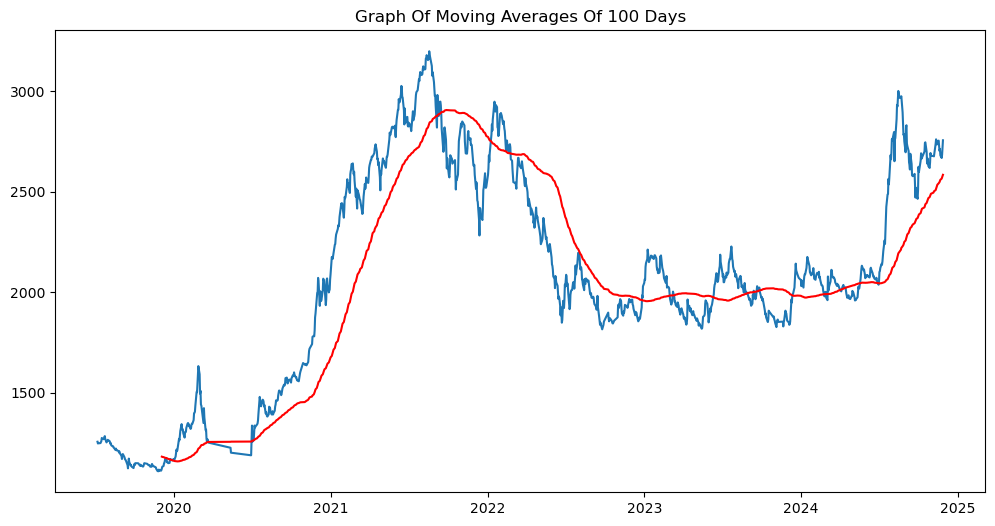

In [14]:
#moving average of 100 days
ma100 = data.Close.rolling(100).mean()
ma100
plt.figure(figsize = (12,6))
plt.plot(data.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

Text(0.5, 1.0, 'Comparison Of 100 Days And 200 Days Moving Averages')

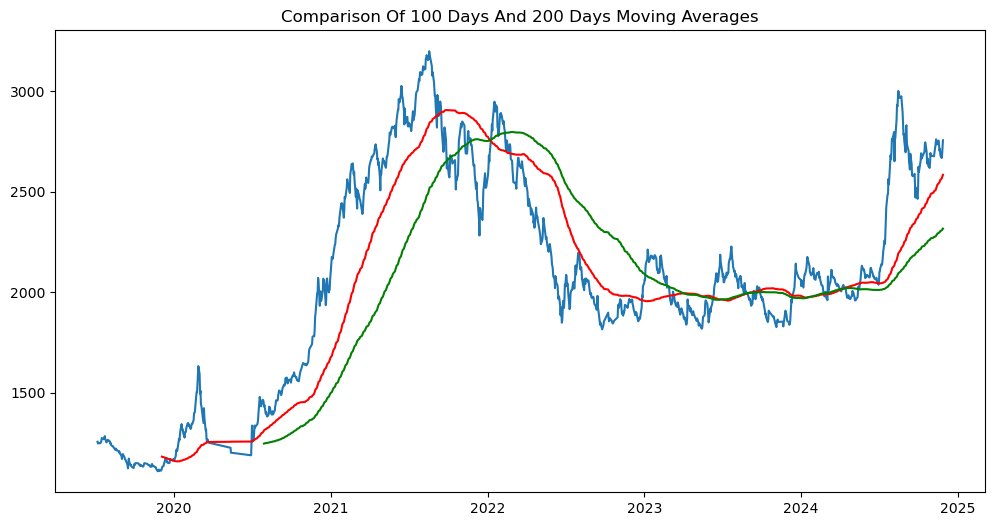

In [15]:
#moving average of 200 days
ma200 = data.Close.rolling(200).mean()
ma200
plt.figure(figsize = (12,6))
plt.plot(data.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparison Of 100 Days And 200 Days Moving Averages')

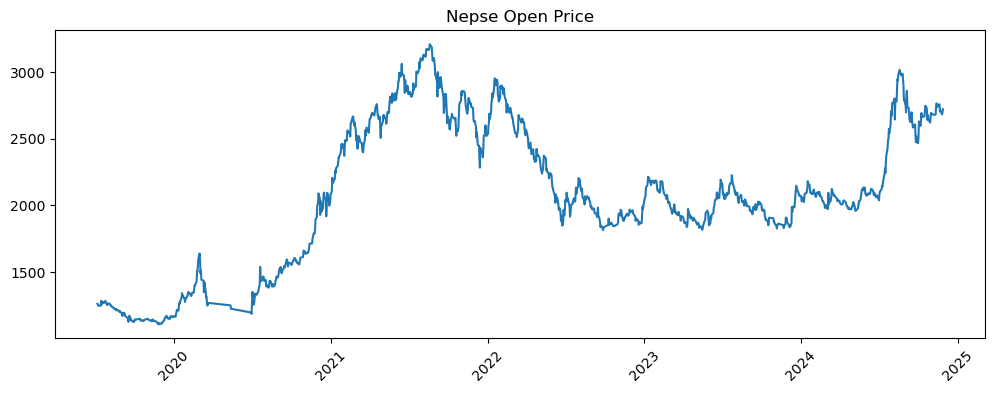

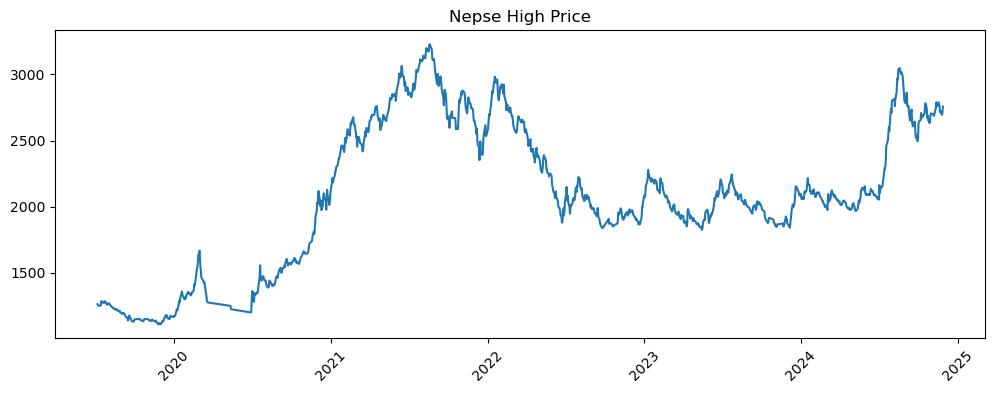

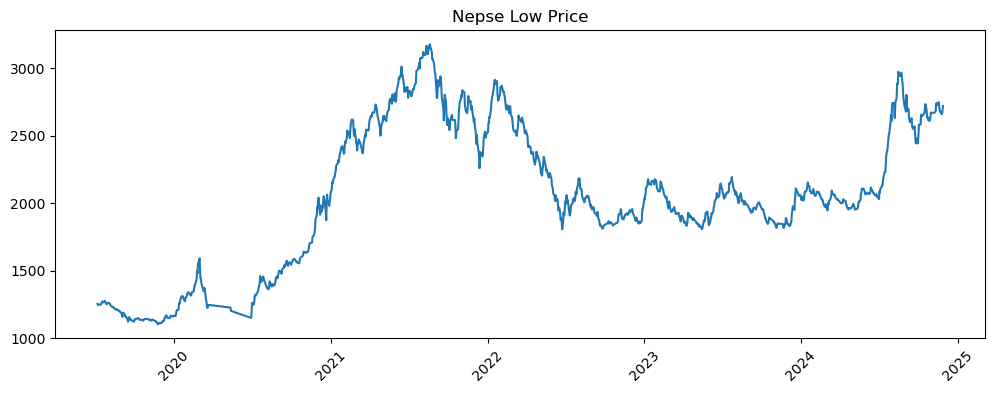

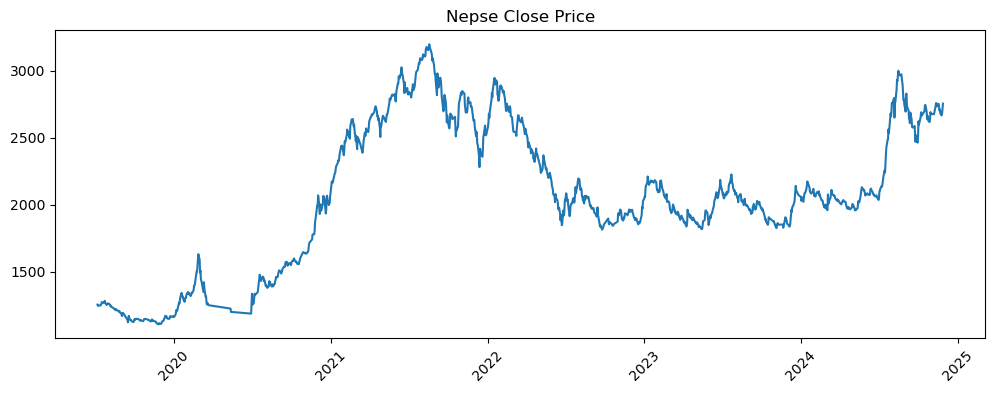

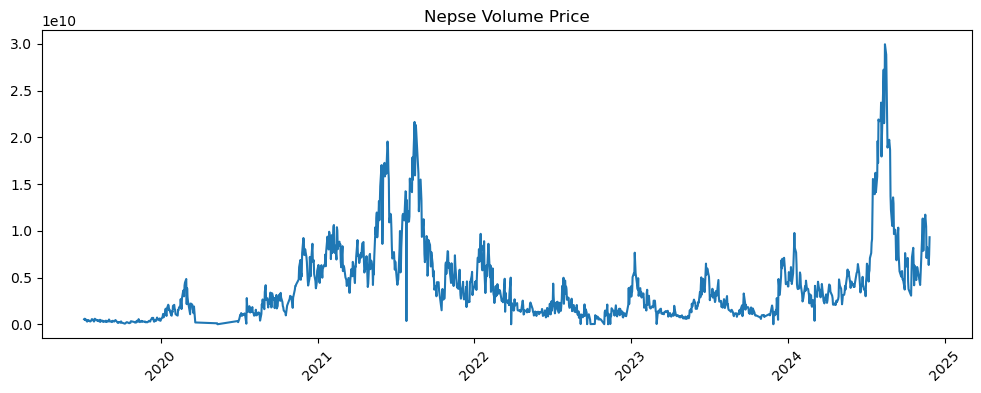

In [16]:
for columns in data.columns:
    plt.figure(figsize=(12,4))
    plt.title(f"Nepse {columns} Price")
    plt.plot(data.index,data[columns])
    plt.xticks(rotation=45)

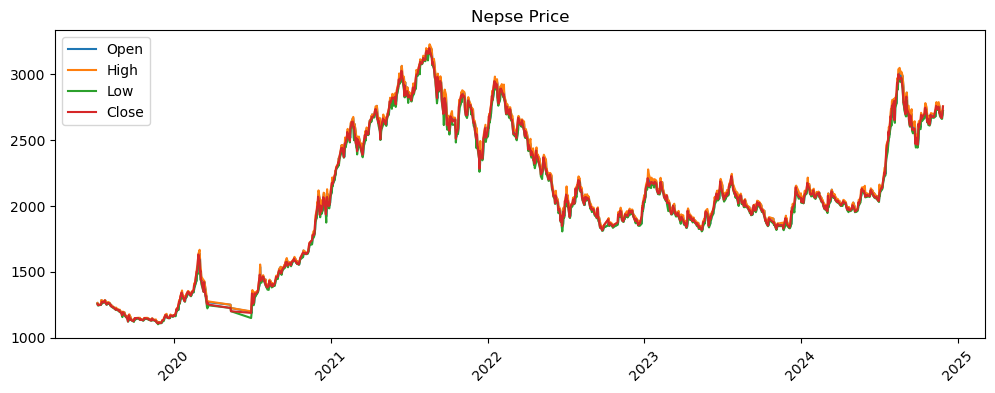

In [17]:
plt.figure(figsize=(12,4))
plt.title("Nepse Price")
for columns in data.columns:
    if(columns !='Volume'):
        plt.plot(data.index,data[columns],label=columns)
plt.xticks(rotation=45)
plt.legend()

In [18]:
data=data['Close']
data.shape

(1221,)

In [19]:
data

Date
2019-07-07    1256.04
2019-07-08    1247.35
2019-07-09    1250.27
2019-07-10    1249.15
2019-07-11    1248.53
               ...   
2024-11-21    2680.44
2024-11-24    2667.40
2024-11-25    2683.24
2024-11-26    2716.66
2024-11-27    2755.47
Name: Close, Length: 1221, dtype: float64

In [20]:
np.array(data)

array([1256.04, 1247.35, 1250.27, ..., 2683.24, 2716.66, 2755.47])

In [21]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1));data

array([[0.07031014],
       [0.06615032],
       [0.0675481 ],
       ...,
       [0.75349803],
       [0.76949589],
       [0.78807389]])

In [22]:
 #we keep the training set as 70% and 30% testing set

training_size=int(len(data)*0.70)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (854, 1)
test_data:  (367, 1)


In [23]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape),print(X_test.shape), print(ytest.shape)

(753, 100)
(753,)
(266, 100)
(266,)


(None, None, None, None)

In [25]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (753, 100, 1)
X_test:  (266, 100, 1)


In [26]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
import tensorflow as tf
from tensorflow import keras

In [27]:
# Define the updated LSTM model with L2 regularization in the Dense layers
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))



# Compile the model with a custom learning rate
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * np.exp(-epoch / 100), verbose=1)
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

C:\Users\Administrator\Desktop\anoconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
# Train the model with Early Stopping and Learning Rate Scheduler
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, ytest),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - loss: 1.1729 - val_loss: 0.8213 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000990049833749168.
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step - loss: 0.7706 - val_loss: 0.6138 - learning_rate: 9.9005e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009801986733067552.
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - loss: 0.5755 - val_loss: 0.4570 - learning_rate: 9.8020e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009704455335485082.
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - loss: 0.4283 - val_loss: 0.3384 - learning_rate: 9.7045e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009607894391523232.
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - loss: 0.3167 - val_loss: 0.2488 - learning_rate: 9.6079e-04

Epoch 6: LearningRateScheduler setting lea

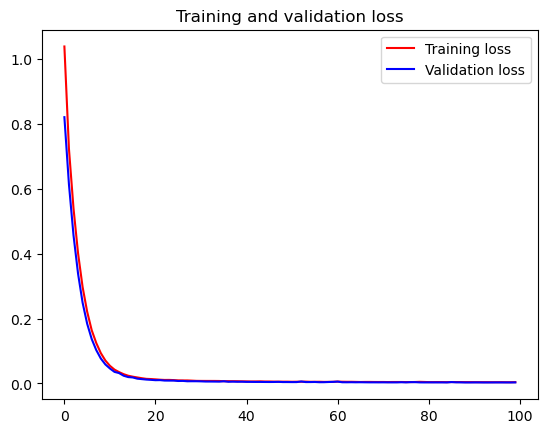

<Figure size 640x480 with 0 Axes>

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [31]:
## Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


((753, 1), (266, 1))

In [32]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [33]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  77.11454804644818
Train data MSE:  5946.653520407964
Train data MAE:  60.745051103398914
-------------------------------------------------------------------------------------
Test data RMSE:  67.57143899993962
Test data MSE:  4565.8993685225605
Test data MAE:  52.82128282131108


In [34]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9791866158241586
Test data explained variance regression score: 0.9567746765534616


In [35]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9791691508920155
Test data R2 score: 0.9563635351588071


In [36]:
#Calculate RMSE performance metrics
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(ytest,test_predict)))

2215.0030611086027
2238.212341727787


In [37]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0016169317600247674
Test data MGD:  0.0008331187949951444
----------------------------------------------------------------------
Train data MPD:  2.947161057163926
Test data MPD:  1.9298599028567394


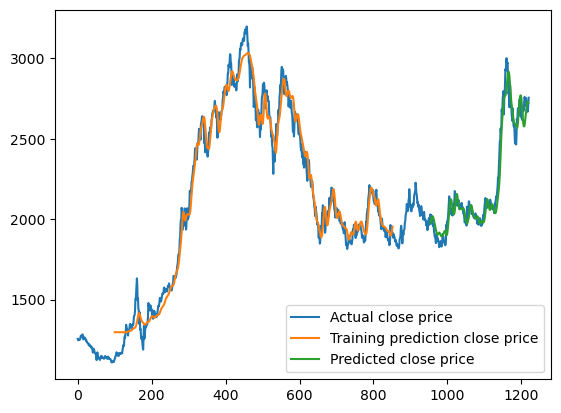

In [38]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data),label="Actual close price")
plt.plot(trainPredictPlot,label="Training prediction close price")
plt.plot(testPredictPlot,label="Predicted close price")
plt.legend()
plt.show()

In [39]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30    # Prediction for next 30 days

while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [40]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)

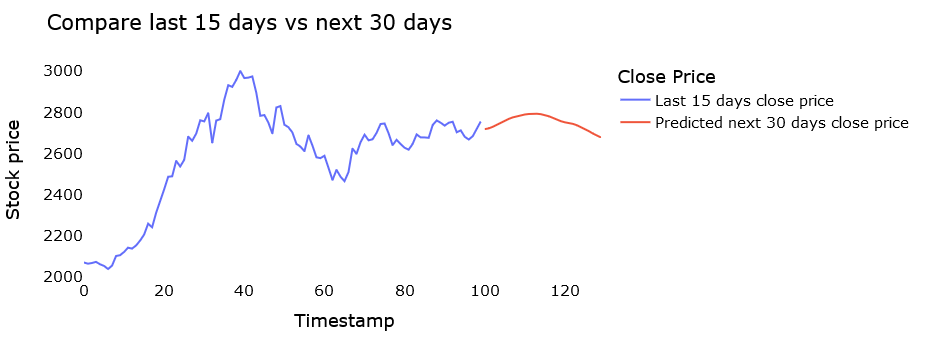

In [41]:
# Initialize the template matrix with NaNs to hold both actual and predicted values
temp_mat = np.empty((len(last_days) + pred_days + 1, 1))
temp_mat[:] = np.nan

# Extract the last actual values and predicted values, then inverse transform them
last_original_days_value = temp_mat.flatten().tolist()
next_predicted_days_value = temp_mat.flatten().tolist()

last_original_days_value[:time_step] = scaler.inverse_transform(data[-time_step:]).flatten().tolist()
next_predicted_days_value[time_step:time_step + pred_days] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).flatten().tolist()

# Create a DataFrame for the plot
new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})
# Cycle through the names for the legend
names = cycle(['Last 15 days close price', 'Predicted next 30 days close price'])

# Create the plot
fig = px.line(new_pred_plot, x=new_pred_plot.index, y=['last_original_days_value', 'next_predicted_days_value'],
              labels={'value': 'Stock price', 'index': 'Timestamp'})

# Update the layout and add proper names to the traces
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.for_each_trace(lambda t: t.update(name=next(names)))

# Update the axes
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show()

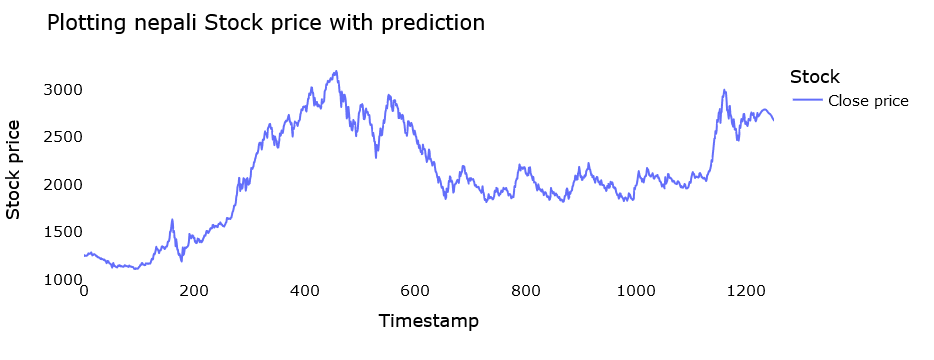

In [42]:
lstmdf=data.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting nepali Stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()